In [2]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

In [269]:
%matplotlib inline
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta as delta
from IPython.display import display, Markdown

In [268]:
dp = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S,%f")

l = pd.read_csv("./part-00000", sep="\t", header=None, names=("at", "level", "msg"), 
                index_col=["at"], parse_dates=["at"])
l.index = l.index.map(lambda x: x + delta(hours=8))
l = l.sort_index()
l.head()

,level,msg
at,,
2017-03-27 08:00:02.832,INFO,Found MAC: 00:15:04:07:D7:4B and SSID: Marshall
2017-03-27 08:00:05.482,INFO,Found MAC: 74:DE:2B:44:EB:B3 and SSID:
2017-03-27 08:00:05.835,INFO,Found MAC: 00:15:04:07:D7:4B and SSID: Marshall
2017-03-27 08:00:05.870,INFO,Found MAC: 00:9C:02:74:06:C2 and SSID: mingau
2017-03-27 08:00:05.969,INFO,Found MAC: 00:9C:02:74:06:C2 and SSID: mingau


In [299]:
display(Markdown("""
### Count: %d
""" % len(l)))


### Count: 36854


In [5]:
pf = pd.read_csv("./phones-mac.csv", header=None, names=("prefix",))
pf.head()

,prefix
0,3C:D9:2B
1,9C:8E:99
2,B4:99:BA
3,1C:C1:DE
4,48:AD:08


In [240]:
import re
mac_pattern = re.compile("[0-9A-F]{2}:[0-9A-F]{2}:[0-9A-F]{2}:[0-9A-F]{2}:[0-9A-F]{2}:[0-9A-F]{2}")

log = l[l.msg.str.contains(mac_pattern)]
log['mac'] = log['msg'].map(lambda y: mac_pattern.search(y).group(0))
# Filter MAC address that are from a Phone manufacturer
p = log[log['mac'].str[0:8].isin(pf['prefix'])]
p = p['2017-03-27 08:20':'2017-03-27 10:00']

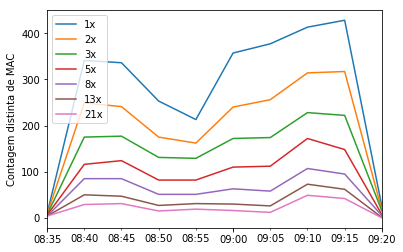

In [234]:
from collections import OrderedDict
from pandas.tseries.offsets import DateOffset
from functools import partial

def repeated_n(data, times):
    c = data.value_counts()
    return c.where(c >= times).count()


fib = OrderedDict([("%sx" % i, partial(repeated_n, times=i)) for i in [1, 2, 3, 5, 8, 13, 21]])

fig = p['mac'].resample('5min').agg(fib).plot()

fig.set_ylabel("Contagem distinta de MAC")
fig.set_xlabel("")
plt.savefig('distinct-by-count.svg', format='svg', dpi=1200)

In [300]:
display(Markdown("""
### Count: %d
""" % len(p)))

p[['mac']].sample(10).sort_index()


### Count: 27261


,mac
at,
2017-03-27 08:42:04.703,1C:56:FE:66:83:53
2017-03-27 08:43:30.086,D0:13:FD:08:9E:D2
2017-03-27 08:46:19.309,F8:CF:C5:B9:BA:1F
2017-03-27 08:50:52.974,30:CB:F8:BF:2B:B0
2017-03-27 09:02:07.758,98:39:8E:66:97:03
2017-03-27 09:06:47.840,40:88:05:04:60:A2
2017-03-27 09:08:39.621,E0:98:61:4D:51:10
2017-03-27 09:10:51.247,68:C4:4D:15:59:44
2017-03-27 09:11:39.259,88:79:7E:89:72:5D


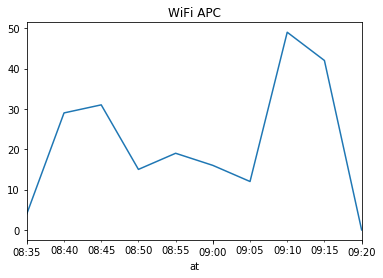

In [217]:
countr = partial(repeated_n, times=21)

c = p['mac'].resample('5min').agg({'count': countr})
c.plot(title="WiFi APC", legend=None)

,occ
at,
2017-03-27 08:36:00,0.3
2017-03-27 08:40:00,0.3
2017-03-27 08:42:00,0.1
2017-03-27 08:45:00,0.1
2017-03-27 08:48:00,0.1
2017-03-27 08:49:00,0.1
2017-03-27 08:51:00,0.1
2017-03-27 08:55:00,0.1
2017-03-27 08:57:00,0.1


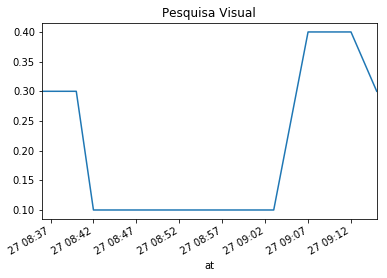

In [165]:
v = pd.read_csv("./visual-2017-03-27.csv",header=None, names=("at", "occ"), 
                index_col=["at"], parse_dates=["at"])
v.index = v.index.map(lambda x: x + delta(minutes=25))
v.plot(title="Pesquisa Visual", legend=None)
v

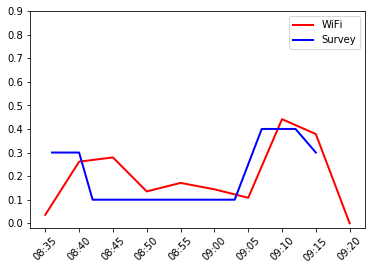

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import signal

BUS_MAX_OCC = 111

x1 = c.index.tolist()
y1 = c['count'].map(lambda y: y / float(BUS_MAX_OCC))
yfilter = signal.medfilt(y1)
zfilter = signal.hilbert(y1)

plt.plot(x1, zfilter, 'r', linewidth=2, label="WiFi")
# plt.bar(x1, y1, 1/500., color='red', label="WiFi")

# Ground truth
x2 = v.index.tolist()
y2 = v['occ'].tolist()
plt.plot(x2, y2, 'b-', linewidth=2, label="Survey")
# plt.bar(x2, y2, 1/600., color='blue', label="Survey")

# Adjust axis output
plt.legend()
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xticks(x1, [dt.strftime(xis, "%H:%M") for xis in x1], rotation=45)

plt.show()

In [264]:
import matplotlib.pyplot as plt
from scipy import stats


def find_nearest_true_value(value):
    after = v[value:]['occ'].tolist()
    before = v[:value]['occ'].tolist()
    
    if after:
        return after[0]
    elif before:
        return before[-1]
        

r = c[0:-1].copy()
r['wifi'] = r['count'].map(lambda y: y / float(BUS_MAX_OCC))
r['truth'] = r.index.map(find_nearest_true_value)
r.sort_index()
r

,count,wifi,truth
at,,,
2017-03-27 08:35:00,4,0.036036,0.3
2017-03-27 08:40:00,29,0.261261,0.3
2017-03-27 08:45:00,31,0.279279,0.1
2017-03-27 08:50:00,15,0.135135,0.1
2017-03-27 08:55:00,19,0.171171,0.1
2017-03-27 09:00:00,16,0.144144,0.1
2017-03-27 09:05:00,12,0.108108,0.4
2017-03-27 09:10:00,49,0.441441,0.4
2017-03-27 09:15:00,42,0.378378,0.3


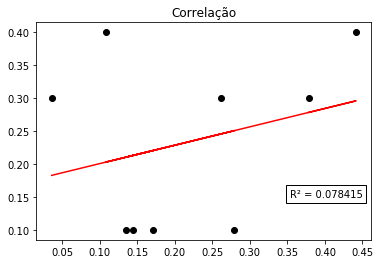

In [168]:
x = r['wifi']
y = r['truth']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.plot(x, y, 'ko', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.title("Correlação")
plt.text(0.45, 0.15, "R² = %f" % r_value ** 2, 
         horizontalalignment='right',
         bbox=dict(facecolor='w'))

# Plot and save
plt.savefig('correlation.svg', format='svg', dpi=1200)
plt.show()

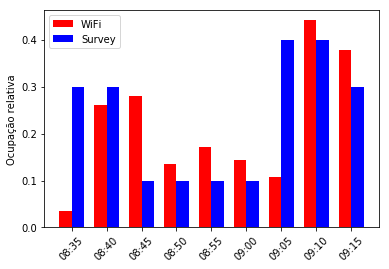

In [195]:
W = 0.35

x = np.arange(len(r))

fig, ax = plt.subplots()
rects1 = ax.bar(x, r['wifi'], W, color='r')
rects2 = ax.bar(x + W, r['truth'], W, color='b')

ax.set_ylabel("Ocupação relativa")
ax.set_xticks(x + W / 2)
ax.set_xticklabels(r.index.map(lambda x: dt.strftime(x, "%H:%M")), rotation=45)

ax.legend((rects1[0], rects2[0]), ('WiFi', 'Survey'))

fig.savefig('bars-wifi-vs-observed.svg', format='svg', dpi=1200)
fig.show()

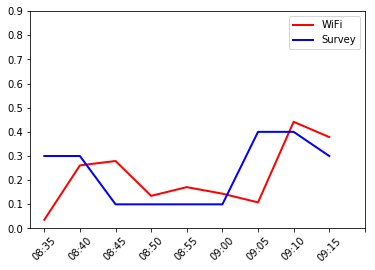

In [251]:
# Graphic
x = r.index.tolist()
y1 = r['wifi']

plt.plot(x, y1, 'r', linewidth=2, label="WiFi")

# Ground truth
y2 = r['truth']
plt.plot(x, y2, 'b-', linewidth=2, label="Survey")

# Adjust axis output
plt.legend()
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xticks(x1, [dt.strftime(xis, "%H:%M") for xis in x], rotation=45)

plt.savefig('lines-wifi-vs-observed.svg', format='svg', dpi=1200)
plt.show()

In [294]:
from scipy.stats import chisquare

# Quis-quare
chi, p_value = chisquare(r['wifi'], r['truth'])

display(Markdown("""
# χ2 = %f 
# valor-P = %f
""" % (chi, p_value)))


# χ2 = 0.878928 
# valor-P = 0.998904


In [287]:
from scipy.stats import power_divergence

# Quis-quare
value, p_value = power_divergence(r['wifi'], r['truth'])

display(Markdown("""
# χ2 = %f 
# valor-P = %f
""" % (value, p_value)))


# χ2 = 0.878928 
# valor-P = 0.998904
